# Aggregate extraced time across multiple traces

1. Input parameters: directory with JSON traces, trace name pattern, (multiple) event patterns.  
   a. In trace name pattern, use one group for the varying parameter value (MBS).
2. For each event pattern, extract event time from all traces one by one using parseOneTrace script.
3. Aggregate values into one DF along with the varying parameter value extracted from the trace filename.


In [47]:
import os
import pandas as pd
import subprocess
import re
import matplotlib
from matplotlib import pyplot as plt

## Set input parameters

In [36]:
logdir = 'logs/mouse.cont/traces/20200729'
trace_name_pattern = 'nsys_trace_([0-9]+).json'
event_patterns = ['.*batchnormalization.*','.*sgemm.*', '.*convolution.*']

## Read trace files

In [37]:
list_command = "ls -1 " + logdir
files = []
param_values = []
proc = subprocess.Popen(list_command.split(" "),
                        stdout=subprocess.PIPE,
                        stderr=subprocess.STDOUT,
                        encoding='utf8')
for line in iter(proc.stdout.readline, ''):
    line = line.strip(" \n")
    m = re.match(trace_name_pattern, line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir, line)))
        param_values.append(m.group(1))

print('{} files in {}'.format(len(files), logdir))
print(tuple(zip(files,param_values)))

12 files in logs/mouse.cont/traces/20200729
(('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_10.json', '10'), ('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_12.json', '12'), ('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_15.json', '15'), ('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_20.json', '20'), ('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_30.json', '30'), ('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_40.json', '40'), ('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_5.json', '5'), ('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_50.json', '50'), ('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_6.

In [38]:
results = None
for param, tracefile in zip(param_values, files):
    events = ' '.join(event_patterns)
    # Run
    # python3 parseOneTrace.py -f $tracefile --events $events
    command = 'python3 parseOneTrace.py -f {} --events {}'.format(tracefile, events)
    print(command)
    p = subprocess.run(command.split(' '), stdin=subprocess.PIPE, stderr=subprocess.PIPE,
                       bufsize=0, shell=False)
    if p.returncode == 0:
        print('Finished OK')
    else:        
        print(p.stdout.decode('utf-8'))
        print('ERROR')
        print(p.stderr.decode('utf-8'))
    # Read data from CSV file
    directory = os.path.dirname(tracefile)
    csvfile = ('').join(os.path.basename(
        tracefile).split('.')[:-1])  # Filename without extension
    csvfile = csvfile + '.csv'
    csvfile = os.path.join(directory, csvfile)
    print('Reading {}'.format(csvfile))    
    df_ = pd.read_csv(csvfile)
    df_['param'] = param
#     display(df_.head())
    if results is None:
        results = df_
    else:
        results = results.append(df_, ignore_index=True)
        
results.sample(n=8)

python3 parseOneTrace.py -f /Users/peterbryzgalov/work/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_10.json --events .*batchnormalization.* .*sgemm.* .*convolution.*
Finished OK
Reading /Users/peterbryzgalov/work/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_10.csv
python3 parseOneTrace.py -f /Users/peterbryzgalov/work/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_12.json --events .*batchnormalization.* .*sgemm.* .*convolution.*
Finished OK
Reading /Users/peterbryzgalov/work/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_12.csv
python3 parseOneTrace.py -f /Users/peterbryzgalov/work/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_15.json --events .*batchnormalization.* .*sgemm.* .*convolution.*
Finished OK
Reading /Users/peterbryzgalov/work/ML/nsystraceparser/logs/mouse.cont/traces/20200729/nsys_trace_15.csv
python3 parseOneTrace.py -f /Users/peterbryzgalov/work/ML/nsystraceparser/logs/mouse.cont/traces/202007

,NVTX,iteration,API event,duration,param
223,"Iteration 3,BWD pass",3,cublasSgemmStridedBatched,0.013871,40
447,"Iteration 5,BWD pass",5,cublasSgemmStridedBatched,0.002965,9
38,"Iteration 5,FWD pass",5,cudnnBatchNormalizationForwardTrainingEx,0.011370,10
175,"Iteration 2,BWD pass",2,cudnnConvolutionBackwardData,0.128977,30
435,"Iteration 3,BWD pass",3,cudnnConvolutionBackwardFilter,0.045321,9
329,"Iteration 5,BWD pass",5,cudnnBatchNormalizationBackwardEx,0.010447,6
352,"Iteration 3,BWD pass",3,cublasSgemm_v2,0.000261,7
6,"Iteration 1,FWD pass",1,cudnnBatchNormalizationForwardTrainingEx,0.011335,10


In [125]:
times = results.copy()
print('API events:',times['API event'].unique())
# Count duplicate entries
times_ = times.groupby(['NVTX', 'iteration', 'API event', 'param'], as_index=False).count()
display(times_[times_['duration'] > 1])
# No duplicates
# SUM time of the same API events in each iteration
times = times.groupby(['iteration', 'API event', 'param'], as_index=False).sum()
display(times.sample(n=5))
# Average between iterations
# Check number of entries
times_ = times.groupby(['API event', 'param'], as_index=False).count()
display(times_[times_['duration'] != 5])
# Have only one iteration for mbs50
times = times.groupby(['API event', 'param'], as_index=False).mean()
times['param'] = times['param'].astype(int)
times.head()

API events: ['cublasSgemmStridedBatched' 'cublasSgemm_v2'
 'cudnnBatchNormalizationBackwardEx' 'cudnnConvolutionBackwardData'
 'cudnnConvolutionBackwardFilter'
 'cudnnBatchNormalizationForwardTrainingEx' 'cudnnConvolutionForward']


,NVTX,iteration,API event,param,duration


,iteration,API event,param,duration
334,5,cudnnBatchNormalizationBackwardEx,10,0.016969
296,4,cudnnConvolutionBackwardFilter,5,0.035000
288,4,cudnnConvolutionBackwardData,8,0.030450
237,4,cublasSgemmStridedBatched,15,0.006050
371,5,cudnnConvolutionBackwardFilter,30,0.118568


,API event,param,iteration,duration
7,cublasSgemmStridedBatched,50,1,1
19,cublasSgemm_v2,50,1,1
42,cudnnBatchNormalizationForwardTrainingEx,50,1,1
76,cudnnConvolutionForward,50,1,1


,API event,param,iteration,duration
0,cublasSgemmStridedBatched,10,3,0.003134
1,cublasSgemmStridedBatched,12,3,0.003958
2,cublasSgemmStridedBatched,15,3,0.006116
3,cublasSgemmStridedBatched,20,3,0.007429
4,cublasSgemmStridedBatched,30,3,0.011677


API event,cublasSgemmStridedBatched,cublasSgemm_v2,cudnnBatchNormalizationBackwardEx,cudnnBatchNormalizationForwardTrainingEx,cudnnConvolutionBackwardData,cudnnConvolutionBackwardFilter,cudnnConvolutionForward
param,,,,,,,
5,0.002574,0.000460,0.010159,0.007249,0.025406,0.037074,0.022149
6,0.002282,0.000419,0.010479,0.006665,0.024745,0.034929,0.021994
7,0.002573,0.000418,0.011961,0.007699,0.027270,0.038766,0.024994
8,0.002758,0.000419,0.013442,0.009604,0.030668,0.041260,0.028564
9,0.002963,0.000424,0.014925,0.010524,0.033955,0.045227,0.030866


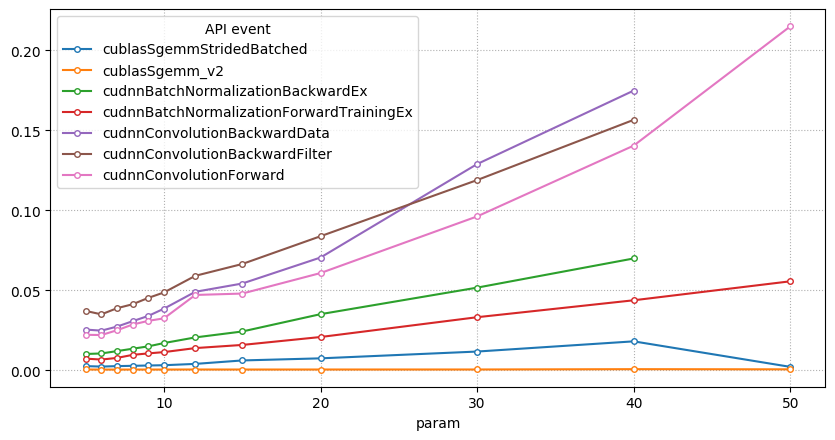

In [120]:
timesT = times.pivot_table(columns='API event', index='param', values='duration',aggfunc='sum')
display(timesT.head())
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
timesT.plot(marker='o', ms=4, mfc='w', ax=ax)
ax.grid(ls=':', which='major')
ax.grid(ls=':', lw=0.5, which='minor')
plt.show()

In [121]:
# Group API events by type
def getType(e):
    types = {'FC': 'sgemm_v2',
             'conv': 'conv',
             'BN': 'batchnormalization'}
    for k, v in types.items():
        m = re.search(v, e.lower())
        if m is not None:
            return k
    return 'other'

In [122]:
# Sum time for same type events
times['type'] = times['API event'].apply(getType)
times = times[(times['type'] != 'other') & (times['param'] != 50)]
times = times.groupby(['type', 'param'], as_index=False).sum()
times['param'] = times['param'].astype(int)
times.head()
times.sample(n=7)

,type,param,iteration,duration
17,FC,12,3,0.000453
29,conv,15,9,0.168537
25,conv,8,9,0.100493
11,FC,5,3,0.000460
10,BN,40,6,0.113591
20,FC,30,3,0.000463
0,BN,5,6,0.017407


In [123]:
timesT = times.pivot_table(columns='type', index='param', values='duration')
timesT.head()

type,BN,FC,conv
param,,,
5,0.017407,0.000460,0.084629
6,0.017144,0.000419,0.081668
7,0.019659,0.000418,0.091030
8,0.023046,0.000419,0.100493
9,0.025450,0.000424,0.110049


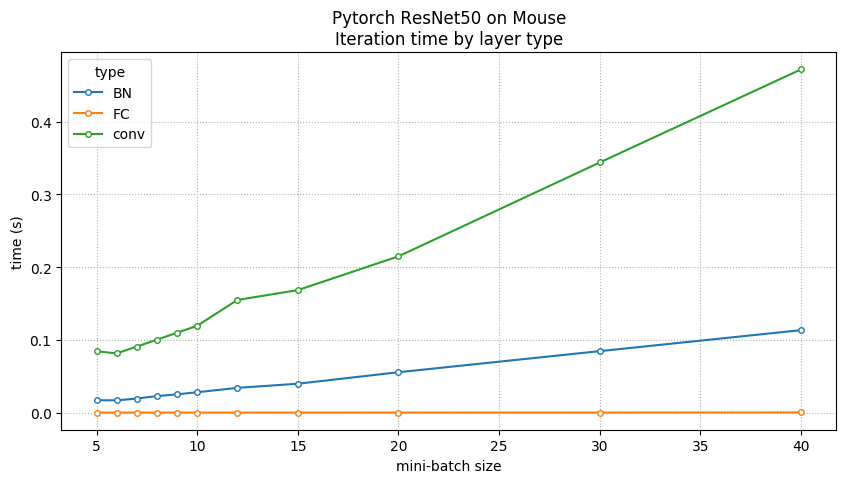

In [124]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
timesT.plot(marker='o', ms=4, mfc='w', ax=ax)
ax.grid(ls=':', which='major')
ax.grid(ls=':', lw=0.5, which='minor')
ax.set_xlabel('mini-batch size')
ax.set_ylabel('time (s)')
plt.title('Pytorch ResNet50 on Mouse\nIteration time by layer type')
plt.show()